In [ ]:
!unzip drive/My\ Drive/2000_fold2_new.zip
!unzip drive/My\ Drive/Test_2000_new.zip

Streaming output truncated to the last 5000 lines.
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/126841-58542.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/130389-62090.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/33706-37254.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/27497-54994.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/104666-53220.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/116197-52333.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-3998FD71628E.svs/118858-29271.jpg  
  inflating: Test_2000_new/Epithelioid/TCGA-UT-A97Y-01Z-00-DX1.19376AE8-F20F-49A8-BD6C-399

In [ ]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,auc
from sklearn.metrics import average_precision_score
import tensorflow as tf
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
import os
import glob
import pandas as pd
from fnmatch import fnmatch

In [ ]:
train_path = "/content/2000_fold2_new/Train"
test_path = "/content/2000_fold2_new/Validation"
val_path ="/content/Test_2000_new"

batch_size = 32

loss_function ='categorical_crossentropy'
epoch = 50

file_pattern = "*.jpg"
folder_pattern = "*TCGA-*"

#reading train and validation data
data_generator = ImageDataGenerator(rescale = 1./255)
#loop and iterating through train images
train_data_generator = data_generator.flow_from_directory(train_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle =True)
#iterating through images of validation set
val_data_generator = data_generator.flow_from_directory(val_path,class_mode ='categorical',batch_size = batch_size,target_size = (224,224),shuffle = True)
#class wight balance

#class wight balance
# classes = train_data_generator.classes
class_weights_list = class_weight.compute_class_weight('balanced',np.unique(train_data_generator.classes),train_data_generator.classes)
weights = dict(zip(np.unique(train_data_generator.classes),class_weights_list))
print("weights ratio to make the dataset balanced: ",weights)

print("class Indices of train generator :",train_data_generator.class_indices)
print("class Indices of validation generator :",val_data_generator.class_indices)

Found 118100 images belonging to 2 classes.
Found 24875 images belonging to 2 classes.
weights ratio to make the dataset balanced:  {0: 0.6483880885453268, 1: 2.1847713482314637}
class Indices of train generator : {'Epithelioid': 0, 'Nonepithelioid': 1}
class Indices of validation generator : {'Epithelioid': 0, 'Nonepithelioid': 1}


In [ ]:
#this function takes the each patch in WSI then predicts the probability score
def pred_each_patch(path,name):
    y = image.load_img(os.path.join(path, name))
    img = image.img_to_array(y)
    y = np.expand_dims(img, axis = 0)
    # y = preprocess_input(y)
    y /= 255
    y_pred = model.predict(y)
    return y_pred
        
def avg(predlist):
    average = sum(predlist)/len(predlist)
    return average

def extract_index_one_frmpred(prediction_list):               
    ypred = np.stack(prediction_list)#we are vertically stacking the predictions
    ypred = np.reshape(ypred, [len(prediction_list),2])#reshaping to 100,2 - np array
    for each in ypred:
    #after reshaping the predictions as we wanted, we are taking the index '1' to compute whole slide level AUC-ROC
        val = each[1]
        pred_prob_list.append(val)#appending all the values into a list - to compute average values of single WSI and maximum of single WSI.
        
    return pred_prob_list
    
def plt_history(history): 
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.tight_layout() 
    plt.show()
    return

def y_labels(path):
  if "Epithelioid" in path:
    y_test_labels.append(0.0)
  elif "Nonepithelioid" in path:
    y_test_labels.append(1.0) 
  return

def prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #AUC - ROC score
  false_pr_avg,true_pr_avg,threshold = roc_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  roc_auc_avg = auc(false_pr_avg,true_pr_avg)
  print("AUC - ROC on Test data average prediction scores:",roc_auc_avg)
  print("-----------------------------------------------------")
  plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
  
  false_pr_max,true_pr_max,threshold = roc_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  roc_auc_max = auc(false_pr_max,true_pr_max)
  print("AUC - ROC on Test data maximum prediction scores:",roc_auc_max)
  print("-----------------------------------------------------")
  plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on test data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.title('ROC curve on Test data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()
 

def pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS):
  #presicion - recall curve
  precision, recall, threshold = precision_recall_curve(y_test_labels,AVG_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data average score predictions:",auc(recall,precision))
 
  print("-----------------------------------------------------")
  plt.plot(precision, recall,color='orange',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall,precision)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

  precision_max, recall_max, threshold = precision_recall_curve(y_test_labels,MAX_LIST_PREDICTIONS)
  print("Presicion - Recall auc on test data maximum score predictions:",auc(recall_max,precision_max))
 
  print("-----------------------------------------------------")
  plt.plot(precision_max, recall_max,color='cyan',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title('Presicion Recall curve on Test data (area = %0.2f)' %(auc(recall_max,precision_max)))
  plt.legend(loc = "lower right")
  plt.tight_layout()
  plt.show()

In [ ]:
model = Sequential()

model.add(Conv2D(filters= 256, input_shape=(224,224,3), kernel_size=(5,5), strides=(2,2), padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(Conv2D(filters= 256, kernel_size=(5,5), strides=(2,2), padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(Conv2D(filters= 512, kernel_size=(5,5), strides=(2,2), padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(Conv2D(filters= 512, kernel_size=(5,5), strides=(2,2), padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(keras.layers.BatchNormalization())

model.add(Conv2D(filters= 1024, kernel_size=(5,5), strides=(2,2), padding='same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
model.add(keras.layers.BatchNormalization())
#we are passing it to fully connected layer
model.add(Flatten())


# 3rd Fully Connected Layer
model.add(Dense(200,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(100,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(50,activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(10,activation = 'relu'))
model.add(Dropout(0.5))
# Output Layer
model.add(Dense(2, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 256)     19456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 256)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 256)       1024      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       1638656   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 512)         3

Epoch 1/50
3690/3690 [==============================] - 665s 180ms/step - loss: 0.7483 - auc: 0.5570 - precision: 0.6013 - recall: 0.6012 - val_loss: 0.6832 - val_auc: 0.7178 - val_precision: 0.7593 - val_recall: 0.7593
Epoch 2/50
3690/3690 [==============================] - 680s 184ms/step - loss: 0.6961 - auc: 0.5914 - precision: 0.6130 - recall: 0.6130 - val_loss: 0.7060 - val_auc: 0.2666 - val_precision: 0.2982 - val_recall: 0.2982
Epoch 3/50
3690/3690 [==============================] - 680s 184ms/step - loss: 0.6849 - auc: 0.6178 - precision: 0.6355 - recall: 0.6355 - val_loss: 1.2846 - val_auc: 0.1881 - val_precision: 0.2298 - val_recall: 0.2298
Epoch 4/50
3690/3690 [==============================] - 678s 184ms/step - loss: 0.6592 - auc: 0.7092 - precision: 0.7096 - recall: 0.7096 - val_loss: 4.6537 - val_auc: 0.1843 - val_precision: 0.2412 - val_recall: 0.2412
Epoch 5/50
3690/3690 [==============================] - 675s 183ms/step - loss: 0.6278 - auc: 0.7556 - precision: 0.7367

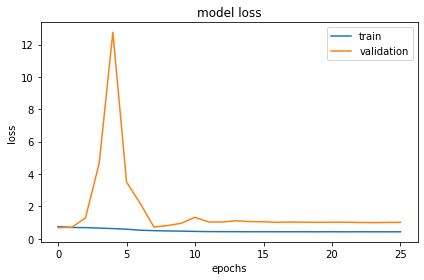

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor = 0.1,patience=5,verbose = 1)
# early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',verbose=1, patience= 25)

opt_nadam = tf.keras.optimizers.Adam(1e-4)#Adam with Nestrov momentum

model.compile(optimizer= opt_nadam, loss=loss_function,metrics = [tf.keras.metrics.AUC(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

#Initilaising the model
history = model.fit(train_data_generator, steps_per_epoch=len(train_data_generator.classes)//batch_size, validation_data=val_data_generator,epochs = epoch,class_weight = weights,callbacks =[es,reduce_lr],workers = 4)
    
plt_history(history)#model_loss_plot 

**Evaluation on validation set**

In [ ]:
AVG_LIST_PREDICTIONS_VAL = []
MAX_LIST_PREDICTIONS_VAL = []
y_val_labels= []
print("Prediction on validation data using aggregation method")
for path, subdirs, files in os.walk(val_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        if "Epithelioid" in path:
          y_val_labels.append(0.0)
        elif "Nonepithelioid" in path:
          y_val_labels.append(1.0) 

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS_VAL.append(avg(predictions))
        MAX_LIST_PREDICTIONS_VAL.append(max(predictions))

Prediction on validation data using aggregation method


AUC - ROC on validation data average prediction scores: 0.51
-----------------------------------------------------


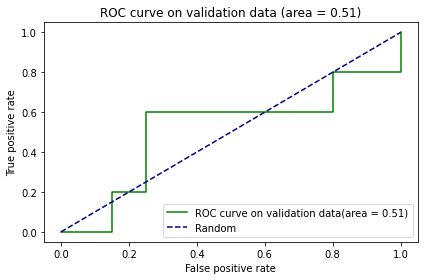

In [ ]:
false_pr_avg,true_pr_avg,threshold = roc_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
roc_auc_avg = auc(false_pr_avg,true_pr_avg)
print("AUC - ROC on validation data average prediction scores:",roc_auc_avg)
print("-----------------------------------------------------")
plt.plot(false_pr_avg,true_pr_avg,color='green',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_avg,true_pr_avg)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

AUC - ROC on validation data maximum prediction scores: 0.49
-----------------------------------------------------


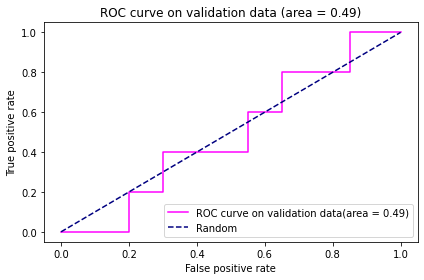

In [ ]:
false_pr_max,true_pr_max,threshold = roc_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
roc_auc_max = auc(false_pr_max,true_pr_max)
print("AUC - ROC on validation data maximum prediction scores:",roc_auc_max)
print("-----------------------------------------------------")
plt.plot(false_pr_max,true_pr_max,color='magenta',label='ROC curve on validation data(area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--',label = 'Random')
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC curve on validation data (area = %0.2f)' %(auc(false_pr_max,true_pr_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

Presicion - Recall auc on validation data average score predictions: 0.208765664160401
-----------------------------------------------------


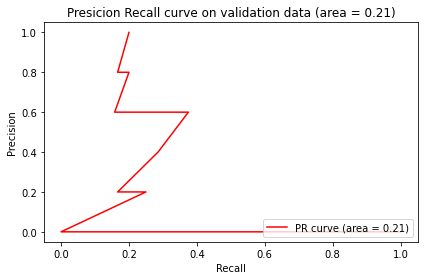

Presicion - Recall auc on validation data maximum score predictions: 0.18015320463849877
-----------------------------------------------------


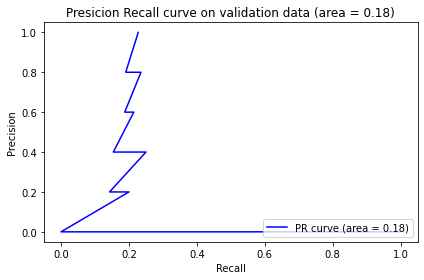

In [ ]:
#presicion - recall curve
precision, recall, threshold = precision_recall_curve(y_val_labels,AVG_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data average score predictions:",auc(recall,precision))
 
print("-----------------------------------------------------")
plt.plot(precision, recall,color='red',label='PR curve (area = %0.2f)' %(auc(recall,precision)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall,precision)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

precision_max, recall_max, threshold = precision_recall_curve(y_val_labels,MAX_LIST_PREDICTIONS_VAL)
print("Presicion - Recall auc on validation data maximum score predictions:",auc(recall_max,precision_max))
print("-----------------------------------------------------")
plt.plot(precision_max, recall_max,color='blue',label='PR curve (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Presicion Recall curve on validation data (area = %0.2f)' %(auc(recall_max,precision_max)))
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
import sklearn
#classification report on average prediction values
AVG_LIST_PREDICTIONS_VAL = [round(x) for x in AVG_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,AVG_LIST_PREDICTIONS_VAL))

print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

#classification report on maximum prediction values
MAX_LIST_PREDICTIONS_VAL = [round(x) for x in MAX_LIST_PREDICTIONS_VAL]
print("CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS")
print(sklearn.metrics.classification_report(y_val_labels,MAX_LIST_PREDICTIONS_VAL))

CLASSIFICATION REPORT for AVERAGE SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.87      0.65      0.74        20
         1.0       0.30      0.60      0.40         5

    accuracy                           0.64        25
   macro avg       0.58      0.62      0.57        25
weighted avg       0.75      0.64      0.67        25

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAXIMUM SCORE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.20      1.00      0.33         5

    accuracy                           0.20        25
   macro avg       0.10      0.50      0.17        25
weighted avg       0.04      0.20      0.07        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**EValuation on Test Set**

In [ ]:
AVG_LIST_PREDICTIONS = []
MAX_LIST_PREDICTIONS = []
y_test_labels= []
print("Prediction on test using aggregation method")
for path, subdirs, files in os.walk(test_path): #iterating through folders of each WSI
    if(fnmatch(path,folder_pattern)):
        WSI_pred = list()
        pred_prob_list = list()
        # print("Iterating through all the patches in: ",os.path.basename(os.path.normpath(path)))
        y_labels(path)

        for name in files:
          if fnmatch(name, file_pattern):#iterating through each patch in all WSI image and computing probabilities
              prediction = pred_each_patch(path,name)
              WSI_pred.append(prediction)#this list contains probabilities of all patches in testset images

        #computing average and maximum prediction of each image - so that we can compute Whole slide level AUC - ROC than patch level
        predictions = extract_index_one_frmpred(WSI_pred)
        #This list contains average score of all 36 test set images
        AVG_LIST_PREDICTIONS.append(avg(predictions))
        MAX_LIST_PREDICTIONS.append(max(predictions))

Prediction on test using aggregation method


AUC - ROC on Test data average prediction scores: 0.7375
-----------------------------------------------------


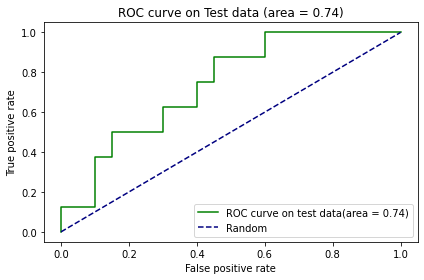

AUC - ROC on Test data maximum prediction scores: 0.68125
-----------------------------------------------------


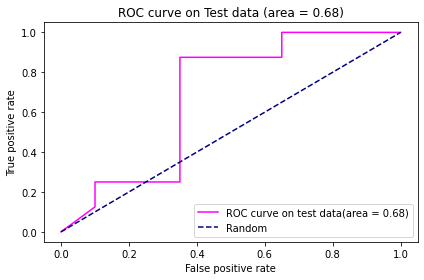

In [ ]:
prediction_scores(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

Presicion - Recall auc on test data average score predictions: 0.5174009515703595
-----------------------------------------------------


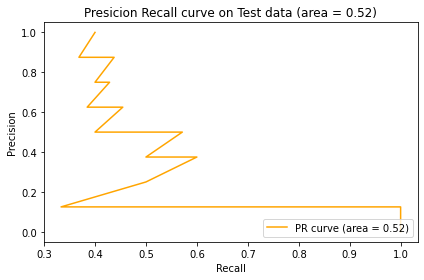

Presicion - Recall auc on test data maximum score predictions: 0.4189702658452658
-----------------------------------------------------


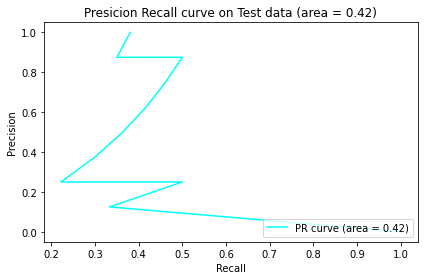

In [ ]:
pre_recall(y_test_labels,AVG_LIST_PREDICTIONS,MAX_LIST_PREDICTIONS)

In [ ]:
from sklearn.metrics import classification_report
AVG_LIST_PREDICTIONS = [round(x) for x in AVG_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT")
print(classification_report(y_test_labels,AVG_LIST_PREDICTIONS))
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
MAX_LIST_PREDICTIONS = [round(x) for x in MAX_LIST_PREDICTIONS]
print("CLASSIFICATION REPORT for MAX VALUE PREDICTIONS")
print(classification_report(y_test_labels,MAX_LIST_PREDICTIONS))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72        20
         1.0       0.42      0.62      0.50         8

    accuracy                           0.64        28
   macro avg       0.61      0.64      0.61        28
weighted avg       0.70      0.64      0.66        28

-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
CLASSIFICATION REPORT for MAX VALUE PREDICTIONS
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        20
         1.0       0.29      1.00      0.44         8

    accuracy                           0.29        28
   macro avg       0.14      0.50      0.22        28
weighted avg       0.08      0.29      0.13        28



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#creating a datframe to save predictions with actuals
df = pd.DataFrame()
df['Average'] = AVG_LIST_PREDICTIONS
df['Maximum'] = MAX_LIST_PREDICTIONS
df['Actual labels'] = y_test_labels
#saving into csv file for futher use
df.to_csv('smallmodel_test_fold2.csv',index = False,header = True)
!cp smallmodel_test_fold2.csv "drive/My Drive/"

In [ ]:
#creating a datframe to save predictions with actuals
df_val = pd.DataFrame()
df_val['Average'] = AVG_LIST_PREDICTIONS_VAL
df_val['Maximum'] = MAX_LIST_PREDICTIONS_VAL
df_val['Actual labels'] = y_val_labels
#saving into csv file for futher use
df_val.to_csv('smallmodel_val_fold2.csv',index = False,header = True)
!cp smallmodel_val_fold2.csv "drive/My Drive/"

In [ ]:
#saving the model
model.save("smallmodel_fold2.h5")
!cp smallmodel_fold2.h5 "drive/My Drive/"